# Propuesta de Investigación Corregida

# Cargar Datos y Descripcion de las Variables

In [71]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis

data = pd.read_csv('diabetes.csv')

# esta variable es propia de estos datos
# no se describe como se obtuvo así que para generalizar se borrara
data.drop('DiabetesPedigreeFunction', axis=1, inplace=True)

data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Age,Outcome
0,6,148,72,35,0,33.6,50,1
1,1,85,66,29,0,26.6,31,0
2,8,183,64,0,0,23.3,32,1
3,1,89,66,23,94,28.1,21,0
4,0,137,40,35,168,43.1,33,1


## Unidades de los datos
Sumamente importante pues no viene incluida como metadata en el archivo de datos, esto es de acuerdo a la pagina en que fueron obtenidos:

- Pregnancies: Cantidad de embarazos
- Glucose: Concentración de glucosa en plasma $mg/dL$
- BloodPressure: Presión distolica $mm Hg$
- SkinThickness: Triceps skin fold thickness $mm$
- Insulin: Insulina en $u U / mL$
- BMI: Indice de Masa Corporal $\frac{Kg}{m^2}$
- Age: Edad en años
- Outcome: 1 para diabetes, 0 para no diabetes

# Codigo Diabetes
Secciones:
- Limpieza de Datos
- Visualizacion de los datos y Correlaciones
- Referencias para la exploración, limpieza y aumento de datos
- Neural Networks

## Limpieza de Datos

In [50]:
# al ver los histogramas se notó que existen BMI's menores a 10
data[data.BMI < 10][:5]
# son 0, lo que significa que no son BMI's correctos, pero producto de error

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Age,Outcome
9,8,125,96,0,0,0.0,54,1
49,7,105,0,0,0,0.0,24,0
60,2,84,0,0,0,0.0,21,0
81,2,74,0,0,0,0.0,22,0
145,0,102,75,23,0,0.0,21,0


In [51]:
# Tambien glucosa 0
# donde <117mmg/dL es no diabetico
# pero se observan de igual forma diabeticos
# podria ser indicativo de tener datos erroneos asi que tambien se limpiaran
data[data.Glucose< 10][:5]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Age,Outcome
75,1,0,48,20,0,24.7,22,0
182,1,0,74,20,23,27.7,21,0
342,1,0,68,35,0,32.0,22,0
349,5,0,80,32,0,41.0,37,1
502,6,0,68,41,0,39.0,41,1


La insulina no tiene sentido que sea 0 para personas sin diabetes, por tanto se consideran como datos faulty;

otra cosa es el metodo utilizado para calcular la insulina que es el inmunoensayo electtroquimioluminiscente el cual entrega hasta un valor limite de $1000 \mu U/mL$, todo valor bajo ese limite es una unidad cuantitativa.
‌

In [72]:
# largo de los datos pre limpieza
pre_len = len(data)

# Lo mismo ocurrira con la insulina
# asi que limpiamos:

data.drop(data[data.BMI == 0].index, inplace=True)
data.drop(data[data.BloodPressure == 0].index, inplace=True)


# la glucosa 0 indica que esta muerto, asi que son datos faulty
data.drop(data[data.Glucose == 0].index, inplace=True)

# limpiamos la insulina faulty
data.drop(data[(data['Insulin'] == 0) & (data['Outcome'] == 1)].index, inplace=True)

post_len = len(data)

In [64]:
print(f"pre limpieza {pre_len} datos")
print(f"popst limpieza {post_len} datos")

print(f"Se eliminó el {(pre_len - post_len)*100/post_len :.2f}% de los datos")

pre limpieza 768 datos
popst limpieza 605 datos
Se eliminó el 26.94% de los datos


In [65]:
# observemos el mayor dato
data[data['Insulin'] > 800]

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Age,Outcome
13,1,189,60,23,846,30.1,59,1


### Aumento de datos

Entre la literatura aparece el indice `HOMA-IR`
de acuerdo a [8] 

"Por su simplicidad y buena correlación con mediciones más complejas de sensibilidad a la insulina, el método más utilizado es el cálculo del índice HOMA-IR (Homeostasis Model Assessment of Insulin Resistance)"

$$
\text{HOMA-IR} = \frac{\text{Glucosa} [mg/dL] \times \text{Insulina} [uU/mL]}{405}
$$

el punto de corte para definir resistencia a la insulina fue definido por Bonora et al [9] (1998) como 2.77
Sin embargo este dependerá de la población en estudio, por ejemplo en Chile el indice de corte se encontraria alrededor de 2.5 con la definición de [9]


Un globulo rojo vive 120 dias, la hemoglobina glicocilada (A1C) mide la glucosa pegada a un globulo rojo,
Por tanto al momento de tomar el examen nos entrega información de hasta 3 meses por este hecho.
Conviertiendola en un buen indiciador

‌
Sin embargo se determina por cromatografia de alta presión y no se tiene ese dato

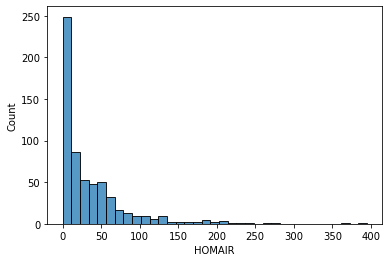

In [66]:
# Agregando el indice a los datos
data['HOMAIR'] = data['Glucose'] * data['Insulin'] / 405

sns.histplot(data.HOMAIR)
plt.show()

guardar los datos limpios y aumentados:

In [73]:
# para resetear los index despues de limpiarlos
data = data.reset_index()
data = data.drop('index', axis=1)

In [74]:
data.to_csv('diabetes_clean.csv')

## Visualizacion de los dato y Correlaciones

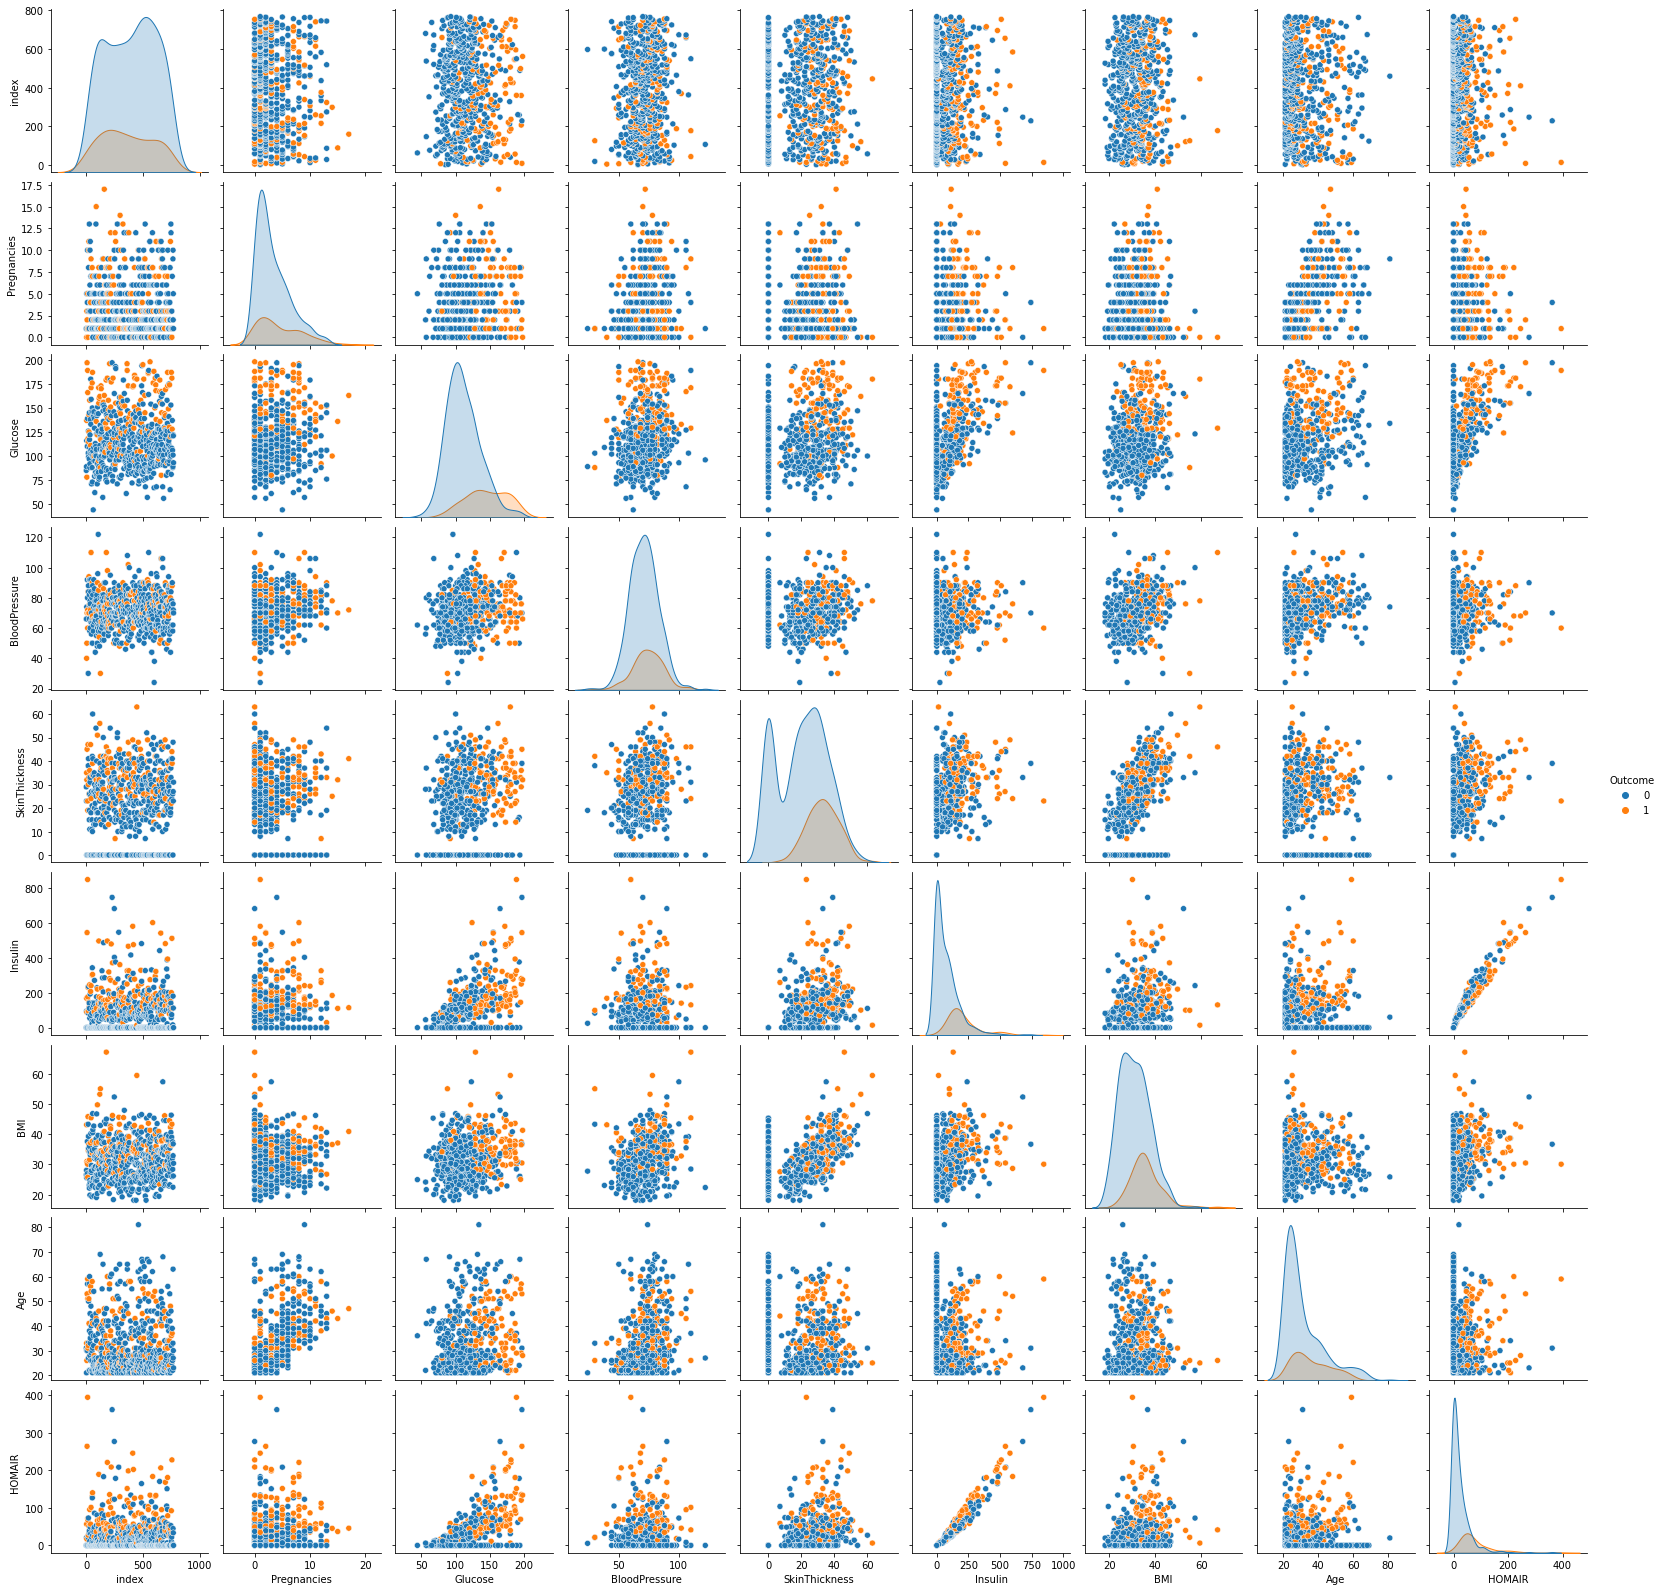

In [10]:
sns.pairplot(data, hue="Outcome")

La visualización de los datos guia la exploración del analista de los datos;
en este caso es posible observar 2 tendencias en las distribuciones (las columnas centrales que presentan los histogramas)
- La glucosa para los diabeticos se encuentra distribuida hacia la derecha
- El BMI para los diabeticos se encuentra distribuido hacia la derecha

Por tanto para comprobar si es una diferencia significativa, se realizara un test de hipotesis no parametrico llamado `Kruskal-Wallis`:

```
Test de la hipotesis nula que las medias de los grupos son iguales (funciona con más de 2 grupos)
Rechazar la hipotesis no indica cual de las muestras difiere
Tampoco entrega información a si es debido a la dispersión de los grupos o en verdad a una media poblacional distinta
```

ver [1] y [2]

In [11]:
from scipy import stats

grupo_no_diabetes = data[data['Outcome']==0]
grupo_diabetes = data[data['Outcome']==1]

In [12]:
def kruskal_wallis_median_test(grupo1, grupo2, variable, explain=True):
    """ Funcion que ordena la respuesta para el test de kruskal wallis"""

    if explain:
        print(f"Hipotesis Nula H0: Las medias de {variable} para los grupos de diabeticos y no diabeticos son iguales")
        print("Hipotesis Alternativa: Las medias de los grupos difieren.")

    p_value = stats.kruskal(grupo_diabetes[variable], grupo_no_diabetes[variable]).pvalue

    if p_value < 0.05:
        print("Tenemos evidencia contra la hipotesis nula")
        print(f"Test KW encuentra una diferencia significativa (p={p_value})")
        print(f"Indicando una diferencia de las medias de la {variable} para los dos grupos")
    elif p_value >= 0.05:
        print("No hay evidencia contra la hipotesis nula")
        print("Por tanto no podemos afirmar que existe evidencia significativa entre")
        print(f"Las medias de los grupos para la variable {variable}")
        print(f"p = {p_value}")

---Glucosa---
Hipotesis Nula H0: Las medias de Glucose para los grupos de diabeticos y no diabeticos son iguales
Hipotesis Alternativa: Las medias de los grupos difieren.
Tenemos evidencia contra la hipotesis nula
Test KW encuentra una diferencia significativa (p=8.137814505541415e-27)
Indicando una diferencia de las medias de la Glucose para los dos grupos


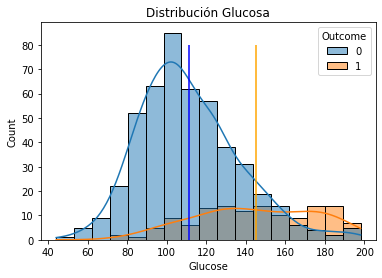

In [13]:
print("---Glucosa---")
kruskal_wallis_median_test(grupo_diabetes, grupo_no_diabetes, 'Glucose')

sns.histplot(data, x='Glucose', kde=True, hue='Outcome')

plt.vlines(grupo_diabetes.mean().Glucose, 0, 80, color='orange',label='media diabeticos')
plt.vlines(grupo_no_diabetes.mean().Glucose, 0, 80, color='blue', label='media NO diabeticos')

plt.title("Distribución Glucosa")
plt.show()

---BMI---
Hipotesis Nula H0: Las medias de BMI para los grupos de diabeticos y no diabeticos son iguales
Hipotesis Alternativa: Las medias de los grupos difieren.
Tenemos evidencia contra la hipotesis nula
Test KW encuentra una diferencia significativa (p=3.936446497482462e-12)
Indicando una diferencia de las medias de la BMI para los dos grupos


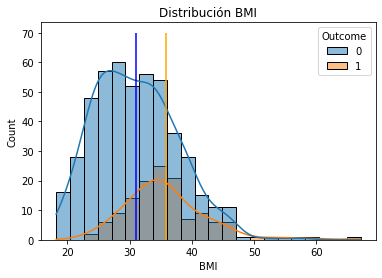

In [14]:
print("---BMI---")
kruskal_wallis_median_test(grupo_diabetes, grupo_no_diabetes, 'BMI')

sns.histplot(data, x='BMI', kde=True, hue='Outcome')

plt.vlines(grupo_diabetes.mean().BMI, 0, 70, color='orange',label='media diabeticos')
plt.vlines(grupo_no_diabetes.mean().BMI, 0, 70, color='blue', label='media NO diabeticos')

plt.title("Distribución BMI")
plt.show()

el BMI juega un rol importante para la clasificación;
puede observarse en articulos como [3]

Donde se observa una correlación del BMI con enfermedades cardiovasculares, sindrome metabolico y diabetes


In [15]:
# Y ahora el resto de las variables:
for variable_test in ['Pregnancies', 'BloodPressure', 'SkinThickness', 'Insulin', 'Age']:
    print(f"---{variable_test}----")
    kruskal_wallis_median_test(grupo_diabetes, grupo_no_diabetes, variable_test, explain=False)
    print("-------------------------------------------------------------------")


---Pregnancies----
Tenemos evidencia contra la hipotesis nula
Test KW encuentra una diferencia significativa (p=0.008908283644870644)
Indicando una diferencia de las medias de la Pregnancies para los dos grupos
-------------------------------------------------------------------
---BloodPressure----
Tenemos evidencia contra la hipotesis nula
Test KW encuentra una diferencia significativa (p=0.004378478255690411)
Indicando una diferencia de las medias de la BloodPressure para los dos grupos
-------------------------------------------------------------------
---SkinThickness----
Tenemos evidencia contra la hipotesis nula
Test KW encuentra una diferencia significativa (p=4.099512899685257e-18)
Indicando una diferencia de las medias de la SkinThickness para los dos grupos
-------------------------------------------------------------------
---Insulin----
Tenemos evidencia contra la hipotesis nula
Test KW encuentra una diferencia significativa (p=3.8645459924613624e-36)
Indicando una diferenc

Luego de este analisis se nota algo interesante;
y es que existe muchas diferencias para las medias de los grupos;
sin embargo no existe una diferencia para la `Insulina`

---Insulina---
Hipotesis Nula H0: Las medias de Insulin para los grupos de diabeticos y no diabeticos son iguales
Hipotesis Alternativa: Las medias de los grupos difieren.
Tenemos evidencia contra la hipotesis nula
Test KW encuentra una diferencia significativa (p=3.8645459924613624e-36)
Indicando una diferencia de las medias de la Insulin para los dos grupos


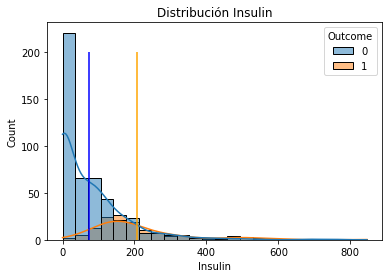

In [16]:
print("---Insulina---")
kruskal_wallis_median_test(grupo_diabetes, grupo_no_diabetes, 'Insulin')

sns.histplot(data, x='Insulin', kde=True, hue='Outcome')

plt.vlines(grupo_diabetes.mean().Insulin, 0, 200, color='orange',label='media diabeticos')
plt.vlines(grupo_no_diabetes.mean().Insulin, 0, 200, color='blue', label='media NO diabeticos')

plt.title("Distribución Insulin")
plt.show()

Existe una diferencia visible en la distribución, pero debido a la distribución de los datos u otros factores como la dispersión podria ser opacada.
Se apoyo en la literatura para expandir más los conocimientos del area, ver sección de referencia.

## Referencias para la exploración, limpieza y aumento de datos

[1]
W. H. Kruskal & W. W. Wallis, “Use of Ranks in One-Criterion Variance Analysis”, Journal of the American Statistical Association, Vol. 47, Issue 260, pp. 583-621, 1952.

[2]
https://en.wikipedia.org/wiki/Kruskal-Wallis_one-way_analysis_of_variance

[3] 
Yoo, B., Nam, H., In Koo Hwang, & Park, Y.-M. (2017). Correlation of Cardiovascular Risk Factors with Central Obesity and Multiple Body Mass Index in Korea. 38(6), 338–338. https://doi.org/10.4082/kjfm.2017.38.6.338

[4]
CDC. (2023, February 28). Diabetes Tests. Centers for Disease Control and Prevention. https://www.cdc.gov/diabetes/basics/getting-tested.html#:~:text=A%20fasting%20blood%20sugar%20level,higher%20indicates%20you%20have%20diabetes.

[5]
Ortiz, J., & Franco Romaní. (2018). Índice triglicéridos/colesterol de alta densidad y perfil lipídico en adolescentes escolares de una región andina del Perú. https://doi.org/10.15381/anales.v79i4.15634

‌[6]
Índice triglicéridos/HDL-colesterol: en una población de adolescentes sin factores de riesgo cardiovascular. (2020). Alanrevista.org. https://www.alanrevista.org/ediciones/2012/2/art-10/

‌[7]
Sujatha, R., & Kavitha, S. (2017). Atherogenic indices in stroke patients: A retrospective study. Iranian Journal of Neurology, 16(2), 78–82. https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5526781/

‌[8]
N Fernando Carrasco, Galgani, E., & J. Marcela Reyes. (2013). Síndrome de resistencia a la insulina. estudio y manejo. 24(5), 827–837. https://doi.org/10.1016/s0716-8640(13)70230-x

‌[9]
Bonora, E., Kiechl, S., Johann Willeit, Friedrich Oberhollenzer, Egger, G., Targher, G., Alberiche, M., Bonadonna, R. C., & Muggeo, M. (1998). Prevalence of insulin resistance in metabolic disorders: the Bruneck Study. 47(10), 1643–1649. https://doi.org/10.2337/diabetes.47.10.1643

‌[10]
Baco, F. (n.d.). Hemoglobina glucosilada o Hb A1c. https://www.galenusrevista.com/IMG/pdf/Hemoglobina.pdf

‌[11]
Guía Clínica 2010 Diabetes Mellitus tipo 2. (n.d.). https://www.minsal.cl/portal/url/item/72213ed52c3e23d1e04001011f011398.pdf

[12]
Algoritmo diagnóstico de la diabetes mellitus tipo 2. (2023). Elsevier.es. https://www.elsevier.es/es-revista-endocrinologia-nutricion-12-pdf-13098543

‌
[13]
www.ilogica.cl, I. (2018, May 8). Prevención de Diabetes Mellitus Tipo 2, detección y manejo inicial de prediabetes. Escuela de Medicina. https://medicina.uc.cl/publicacion/prevencion-diabetes-mellitus-tipo-2-deteccion-manejo-inicial-prediabetes/

‌
[14]
ALAD. (n.d.). https://www.revistaalad.com/guias/5600AX191_guias_alad_2019.pdf

[15]
Insulina Insulina (CLIA) Información para pedidos Uso previsto. (n.d.). https://desego.com/wp-content/uploads/2021/06/Reactivo-Insulin-2X-50.pdf

‌
‌

### PCA | Data Segmentation Hypothesis
Existe una posible segmentación en los datos en base a PCA con las variables:
- Edad
- BMI
- Pregnancies



In [17]:
def PCA_KNN(X,y,name,n_neighbors):
    # Split de train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.5, random_state=42
    )

    # Reduce dimension to 2 with PCA
    pca = make_pipeline(StandardScaler(), PCA(n_components=2, random_state=42))
    pca.fit(X_train, y_train);

    # KNN
    knn = KNeighborsClassifier(n_neighbors=n_neighbors);

    # KKN fit
    knn.fit(pca.transform(X_train), y_train)
    # accurarcy del KNearestN
    acc_knn = knn.score(pca.transform(X_test), y_test)

    # Transformacion a 2D
    X_embedded = pca.transform(X)

    sc = plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=y, s=30, cmap="Set1")
    plt.colorbar(sc)
    plt.title(
        "{}\nTest accuracy = {:.2f}".format(name,acc_knn)
        )
    plt.show()

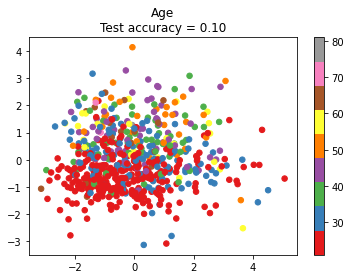

In [18]:
# Edad
X, y = data.loc[:,:'BMI'], data['Age']
PCA_KNN(X,y,name='Age',n_neighbors=2)


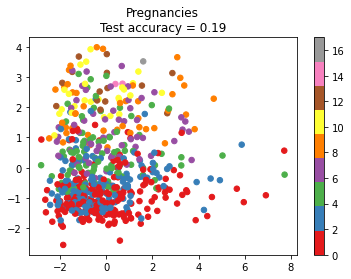

In [19]:
# Pregnancies
X, y = data.drop(['Outcome'], axis=1), data['Pregnancies']
PCA_KNN(X,y,name='Pregnancies',n_neighbors=2)


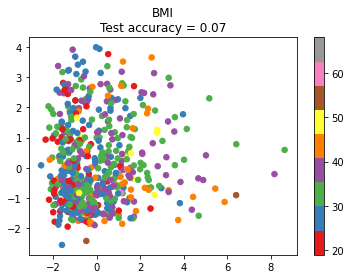

In [20]:
# BMI
X, y = data.drop(['Outcome','BMI'], axis=1), np.ceil(data['BMI'].values)
PCA_KNN(X,y,name='BMI',n_neighbors=2)


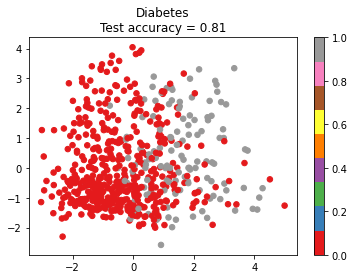

In [21]:
# Diabetes
X, y = data.loc[:,:'Age'], data['Outcome']
PCA_KNN(X,y,name='Diabetes',n_neighbors=2)

# existe una segmentación de datos bastante buena para el diabetes

Conclusión:
No hay una segmentación directa mediante las variables por si solas en el contexto de un PCA en 2 dimensiones
- Age
- BMI
- Pregnancies

Sin embargo el PCA provee un buen primer intento para identificar el diabetes, logrando una precisión por encima del 60%. Por lo que arroja esperanza a poder realizar un identificador más poderoso.

### Hipotesis 2:
Es posible identificar o separar los datos de diabeticos con una precisión mayor del 60% utilizando unicamente en combinación
- Age
- BMI
- Pregnancies


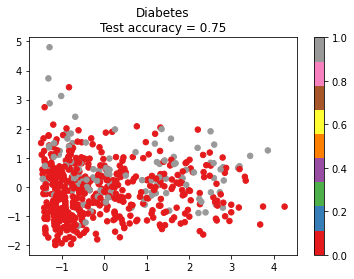

In [22]:
# Diabetes
X, y = data[['Age','BMI','Pregnancies']], data['Outcome']
PCA_KNN(X,y,name='Diabetes',n_neighbors=2)

Conclusión: Utilizando unicamente las variables visuales es posible predecir la diabetes con un 60%; es una precisión baja y podria ser producto de estar trabajando unicamente con el BMI como un indicador

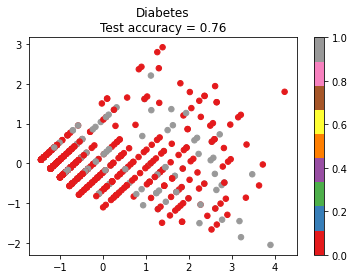

In [23]:
# Diabetes
X, y = data[['Age','Pregnancies']], data['Outcome']
PCA_KNN(X,y,name='Diabetes',n_neighbors=2)

descontar el BMI produce un resultado similar al 60%.

El uso de estos test funcionan para ver si existe algun indicador poderoso a simple vista que no requiera de la artilleria pesada de la computación.

Usar las 3 variables visibles como primer indicador podria resultar siendo un buen inicio.

# Neural Networks

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis

data = pd.read_csv('diabetes_clean.csv', index_col=0)

print(len(data))
data.head()

605


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,Age,Outcome
0,1,85,66,29,0,26.6,31,0
1,1,89,66,23,94,28.1,21,0
2,0,137,40,35,168,43.1,33,1
3,5,116,74,0,0,25.6,30,0
4,3,78,50,32,88,31.0,26,1


In [76]:
# cosas de Red Neuronal

import torch.nn as nn
import torch

from torch.optim import SGD, Adam
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn.init as init

Las técnicas de normalización se utilizan para escalar y transformar las características (variables) de un conjunto de datos con el objetivo de que todas las características tengan la misma escala o distribución. Esto es útil para evitar que una característica domine sobre las demás debido a su rango o magnitud.

- The maximum absolute scaling: Esta técnica escala los valores de las características al dividir cada valor por el máximo valor absoluto encontrado en el conjunto de datos. Esto asegura que todos los valores estén en el rango de -1 a 1. Es una técnica útil cuando se desea mantener la relación de magnitud entre las características, pero se elimina la información sobre la distribución original.

- The min-max feature scaling: En esta técnica, los valores de las características se escalan al rango específico, generalmente entre 0 y 1. Se calcula restando el valor mínimo de cada característica y dividiendo por la diferencia entre el valor máximo y el valor mínimo. Esta técnica preserva la relación de magnitud y la distribución relativa de los datos originales.

- The z-score method: Esta técnica también se conoce como estandarización. Se basa en la transformación de los valores de las características para que tengan una media cero y una desviación estándar de uno. Para lograr esto, se resta la media de cada característica y se divide por su desviación estándar. La estandarización es útil cuando se desea que los datos tengan una distribución normal con media cero y varianza uno.

- The robust scaling: Esta técnica está diseñada para manejar datos con valores atípicos (outliers). Utiliza una mediana y una medida de dispersión robusta, como el rango intercuartil (IQR), en lugar de la media y la desviación estándar. Los valores se escalan restando la mediana y dividiendo por el IQR. Esto hace que la técnica sea más resistente a los valores atípicos y adecuada para conjuntos de datos con distribuciones no normales.


In [77]:
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

# Min Max Scaler
scaler = MinMaxScaler()
df_norm = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)

# Max Abs Scaler
abs_scaler = MaxAbsScaler()
abs_scaler.fit(data)
scaled_data = abs_scaler.transform(data)
df_scaled = pd.DataFrame(scaled_data, columns=data.columns)

# Standard Scaler
std_scaler = StandardScaler()
df_std = pd.DataFrame(std_scaler.fit_transform(data), columns=data.columns)

# Robust Scaler
scaler = RobustScaler()
df_robust = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)


# Tenemos así los datos
normalized_data = {'norm': df_norm,
    'scaled': df_scaled, 'standarized': df_std, 'robust': df_robust}


es posible ver la diferencia visualmente de las escalas,
eventualmente se desea usar estas 4 normalizaciones de los datos con las distintas configuraciones de la red de manera de encontrar los hiperparametros optimos

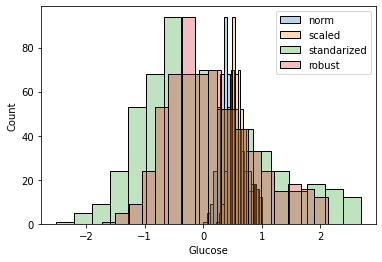

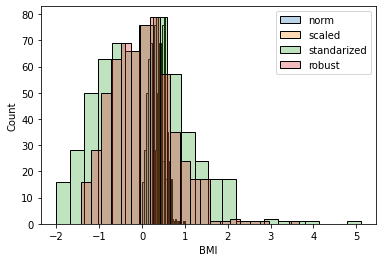

In [27]:
keys = ['norm', 'scaled', 'standarized', 'robust']

for k in keys:
    X = normalized_data[k].Glucose
    sns.histplot(X,label=k,alpha=0.3)
plt.legend()
plt.show()

for k in keys:
    X = normalized_data[k].BMI
    sns.histplot(X,label=k,alpha=0.3)
plt.legend()
plt.show()

In [29]:
# A partir de un grupo de datos entregados, obtener entrenamiento, test y validacion
def get_data(data_selected, p_train=0.8, p_validation=0.5, random_state=42):
    """
    Input: pandas dataset con columna de Outcome como targets

    Output: Pytorch Tensors
        X_train, X_test, X_valid, y_train, y_test, y_valid

    p_train es el porcentaje de datos a dejar en entrenamiento
    luego de los datos restantes
    p_validation indica el porcentaje de esos datos restantes para validacion

    random_state se refiere al estado aleatorio para decidir que valores tomar

    """
    # Normalmente separamos los features de los targets
    X, y = data_selected.drop(['Outcome'], axis=1), data_selected['Outcome']


    # Separar los datos
    X, y = torch.Tensor(X.values), torch.Tensor(y.values)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=p_train, random_state=42
        )

    X_test, X_valid, y_test, y_valid = train_test_split(
        X_test, y_test, test_size=p_validation, random_state=random_state
        )

    return X_train, X_test, X_valid, y_train, y_test, y_valid

In [ ]:
# keys = ['norm', 'scaled', 'standarized', 'robust']
# for key in keys:
#     data_selected = normalized_data[key]
#     X_train, X_test, X_valid, y_train, y_test, y_valid = get_data(data_selected)
#     print(key)
#     print(model(X_train)[:5])

sobre funciones de activación

Text(0.5, 1.0, 'Funcion activacion: LeakyReLU')

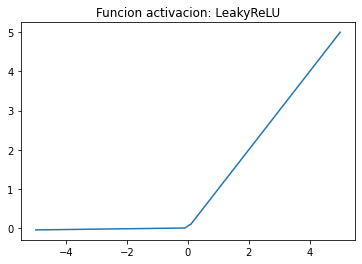

In [ ]:
x = torch.linspace(-5,5,50)
lrelu = nn.LeakyReLU()
plt.plot(x, lrelu(x))
plt.title("Funcion activacion: LeakyReLU")

Text(0.5, 1.0, 'Sigmoide -> Probabilidad')

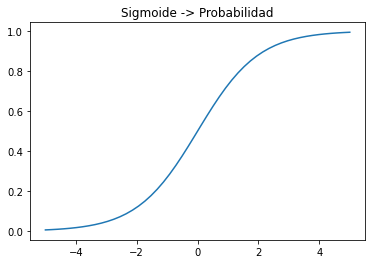

In [ ]:
x = torch.linspace(-5,5,50)
sigmoid = nn.Sigmoid()
plt.plot(x, sigmoid(x))
plt.title("Sigmoide -> Probabilidad")

La red que usa toda la información

In [ ]:
import torch.nn.functional as F

In [ ]:
class NN_Diabetes(nn.Module):
    def __init__(self, input_size = 8, hidden1 = 20, hidden2 = 20, out_features = 1):
        super().__init__()
        
        self.f_connected1 = nn.Linear(input_size, hidden1)
        self.f_connected2 = nn.Linear(hidden1, hidden2)  
        self.out = nn.Linear( hidden2, out_features)      
        
    def forward(self, x):
        x = F.relu(self.f_connected1(x))
        x = F.relu(self.f_connected2(x))
        x = self.out(x)
        return x



In [112]:
class CompleteNetwork(nn.Module):
    def __init__(self, input_size, max_depth, width_multiplier=3):
        super(CompleteNetwork, self).__init__()
        
        self.input_size = input_size
        self.max_depth = max_depth
        self.size = input_size*width_multiplier

        funcion_activacion_1 = nn.ReLU()
        funcion_activacion_2 = nn.Tanh()

        # Construcción de las capas
        layers = []

        layer = nn.Linear(self.input_size, self.size)
        init.xavier_uniform_(layer.weight)  # Inicialización de Xavier
        layers.append(layer)
        layers.append(funcion_activacion_1)
        
        # Se expanden
        depth = max_depth//2
        for i in range(1,depth+1):
            layer = nn.Linear(self.size * i, self.size * (i + 1))
            init.xavier_uniform_(layer.weight)  # Inicialización de Xavier
            layers.append(layer)
            layers.append(funcion_activacion_1)


        for i in range(depth,0,-1):
            layer = nn.Linear(self.size * (i+1), self.size * (i))
            init.xavier_uniform_(layer.weight)  # Inicialización de Xavier
            layers.append(layer)
            layers.append(funcion_activacion_2)

        
        # hasta acabar con solo una sigmoide
        layer = nn.Linear( self.size * (i),1)
        init.xavier_uniform_(layer.weight)  # Inicialización de Xavier
        layers.append(layer)
        # layers.append( nn.Linear(self.input_size,1))
        layers.append(nn.Sigmoid())


        self.layers = nn.Sequential(*layers)

    def forward(self, X):
        return self.layers(X)
        
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    

In [113]:
# construccion del modelo
n_features = 7
max_depth = 2
width_multiplier=2

# Instancia
model = CompleteNetwork(n_features, 
    max_depth, width_multiplier)

#model = NN_Diabetes()

# Obtener el número total de parámetros
total_params = count_parameters(model)
print("Número total de parámetros: ", total_params)

model

Número total de parámetros:  953


CompleteNetwork(
  (layers): Sequential(
    (0): Linear(in_features=7, out_features=14, bias=True)
    (1): ReLU()
    (2): Linear(in_features=14, out_features=28, bias=True)
    (3): ReLU()
    (4): Linear(in_features=28, out_features=14, bias=True)
    (5): Tanh()
    (6): Linear(in_features=14, out_features=1, bias=True)
    (7): Sigmoid()
  )
)

In [114]:
# Para el primer entranmeinto, usare los standar
data_selected = normalized_data['standarized']
# para no normalizar los labels
data_selected['Outcome'] = data['Outcome']

# Luego se separan
X_train, X_test, X_valid, y_train, y_test, y_valid = get_data(data_selected, 
    p_train=0.6, p_validation=0.6)

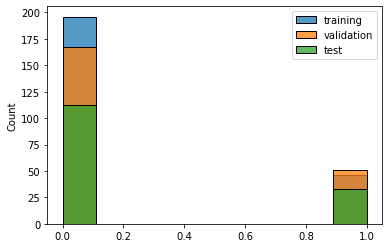

In [115]:
sns.histplot(y_train, label='training')
sns.histplot(y_valid, label='validation')
sns.histplot(y_test, label='test')
plt.legend()
plt.show()

In [116]:
lr = 0.005

# Cross Entropy
# La entropia mide la incertidumbre
# muy util para resultados binarios
loss_fn   = nn.MSELoss()  
optimizer = Adam(model.parameters(), lr=lr)
 
# el scheduler se encarga de tener un learning rate que varia ciclicamente
# de manera que permite pegar grandes saltos asi como ser muy pequeño
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.25, total_iters=30)

In [117]:
n_epochs = 190
batch_size = 11

In [118]:
# Donde guardar los errores
loss_array_training = []
loss_array_validation = []

In [119]:
X_train.shape

torch.Size([242, 7])

In [120]:
# ---------------- Training ----------------
min_loss = 1e20
epsilon = 1e-5

running_loss = 0
for epoch in range(n_epochs):
        
    for i in range(0, len(X_train), batch_size):

        Xbatch = X_train[i:i+batch_size]
        y_pred = model(Xbatch)
        ybatch = y_train[i:i+batch_size].reshape(-1,1)
        loss = loss_fn(y_pred, ybatch)
        
        running_loss += float(loss.detach())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    
    loss_array_training.append(running_loss)

    with torch.no_grad():
        y_pred = model(X_valid)
        loss_validation = loss_fn(y_pred, y_valid.reshape(-1,1))
        #print(loss.detach())
        loss_array_validation.append(loss_validation.detach())

    if epoch % 5 == 0:
            print(f'epoch {epoch}, loss epoch {loss}')

    # Cuando detener el entrenamiento
    if float(loss_validation.detach()) > float(running_loss):
        print('break por overfitting')
        break
    elif np.abs(float(running_loss) - min_loss) < epsilon:
        print('break por loss estatico')
        break
        

    # actualiza Learning Rate
    scheduler.step()
    
    
    min_loss = np.minimum(running_loss, min_loss)
    running_loss = 0
    

    
    

epoch 0, loss epoch 0.018872560933232307
epoch 5, loss epoch 0.008486042730510235
epoch 10, loss epoch 0.006665420718491077
epoch 15, loss epoch 0.0073997993022203445
epoch 20, loss epoch 0.007146821822971106
epoch 25, loss epoch 0.00570646533742547
epoch 30, loss epoch 0.0030243180226534605
epoch 35, loss epoch 0.002251249738037586
epoch 40, loss epoch 0.0017090491019189358
epoch 45, loss epoch 0.0010756071424111724
epoch 50, loss epoch 0.000937700446229428
epoch 55, loss epoch 0.0007280692807398736
epoch 60, loss epoch 0.0006139103788882494
epoch 65, loss epoch 0.0005085538723506033
epoch 70, loss epoch 0.0003836791729554534
epoch 75, loss epoch 0.0003881051088683307
epoch 80, loss epoch 0.0003741334949154407
epoch 85, loss epoch 0.00030542819877155125
epoch 90, loss epoch 0.0001984708069358021
epoch 95, loss epoch 0.00017337713507004082
epoch 100, loss epoch 0.0001263924641534686
epoch 105, loss epoch 0.0001393734128214419
epoch 110, loss epoch 0.00016813393449410796
epoch 115, loss

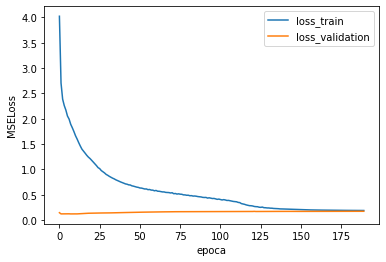

Preicisón del Modelo para Test 65.218%


In [122]:
# Evolución del Loss en el training
plt.plot(loss_array_training, label='loss_train')
plt.plot(loss_array_validation, label='loss_validation')
plt.xlabel('epoca')
plt.ylabel('MSELoss')
plt.legend()
plt.show()

model.eval();
X_test = torch.Tensor(X_test)

# Precisión del Modelo para Datos No Vistos
y_pred = model(X_test)
accuracy = (y_pred.round() == y_test).float().mean()
print(f"Preicisón del Modelo para Test {100*accuracy :.3f}%")

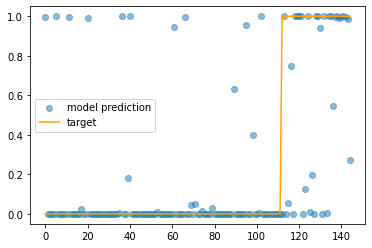

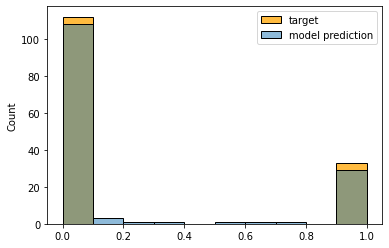

In [127]:
# Observar como se ve la predicción

# Obtener los índices que ordenan y_test en orden ascendente
sorted_indices = np.argsort(y_test)

# Ordenar y_test y X_test utilizando los índices obtenidos
s_y_test = y_test[sorted_indices]
s_X_test = X_test[sorted_indices]

# como se ve el testing
plt.scatter(np.arange(len(s_X_test)),model(s_X_test).detach(), label='model prediction', alpha=0.5)
plt.plot(s_y_test, label='target', color='orange')
plt.legend()
plt.show()

# como se ve el testing BAR PLOT
sns.histplot(s_y_test, label='target', color='orange', bins=10)
# probar con disintos bin size aqui:
sns.histplot(model(s_X_test).detach(), label='model prediction', bins=10)
plt.legend()
plt.show()

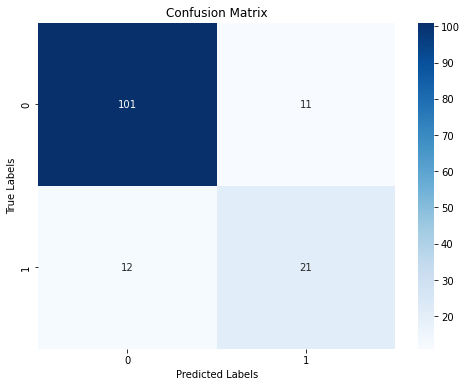

In [129]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create the confusion matrix
cm = confusion_matrix(s_y_test, predicted_labels)

# Create a heatmap of the confusion matrix using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and axis ticks
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")

# Display the plot
plt.show()
